### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
# We use models.Model which is the same as keras.Model
import tensorflow.keras.layers as layers

In [3]:
print(tf.__version__)
print(keras.__version__)

2.4.0
2.4.0


### Data setup

In [4]:
# load data
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [5]:
# adjust label values
y_train_valid -= 769
y_test -= 769

In [6]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [7]:
# split into train and validation set. Assumes iid
perm = np.random.permutation(X_train_valid.shape[0])
numTrain = int(0.8*X_train_valid.shape[0])
numVal = X_train_valid.shape[0] - numTrain
Xtrain = X_train_valid[perm[0:numTrain]]
ytrain = y_train_valid[perm[0:numTrain]]
Xval = X_train_valid[perm[numTrain: ]]
yval = y_train_valid[perm[numTrain: ]]

### Fully-connected (Dense) and RNN layers. Compiling a model.

In [8]:
hidden_dim = 20

In [9]:
# Building a Sequential model:
model = models.Sequential()
model.add(layers.Permute((2, 1), input_shape=(22, 1000))) # (batch, 22, 1000) -> (batch, 1000, 22)
model.add(layers.SimpleRNN(hidden_dim)) # (batch, 1000, 22) -> (batch, hidden_dim)
                                        # Use return_sequences=True to use in cascaded RNNs
model.add(layers.Dense(4, activation='softmax')) # (batch, hidden_dim) -> (batch, 4)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])\
    # Need to compile model before running
    # use optimizer='sgd' if desired. Seems to be case-insensitive
    # use loss = 'categorical_crossentropy' for one-hot labels
    # see https://www.tensorflow.org/api_docs/python/tf/keras/metrics for other metrics.
    #     Metrics might not have string names.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 1000, 22)          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20)                860       
_________________________________________________________________
dense (Dense)                (None, 4)                 84        
Total params: 944
Trainable params: 944
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Equivalent functional declaration:
inputs = layers.Input(shape=(22, 1000), name='inputs')
    # Needed for first layer. Expects input of (batch, 22, 1000)
    # We can also name our layers. Useful for getting a layer by a string name.
p1 = layers.Permute((2, 1), name='p1')(inputs)
    # Format is ClassName(*args, **kwargs)(upstream_layer)
    # Permute: count batch dimension as 0
rnn = layers.SimpleRNN(hidden_dim, name='rnn')(p1)
outputs = layers.Dense(4, activation='softmax', name='outputs')(rnn)
model = models.Model(inputs=inputs, outputs=outputs, name='functional_model') # or keras.Model(*, **)
    # Need to declare a model specifying input and output layers.
    # Can pass lists of layers instead.
    # We can also name our model.
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc']) # Compiling is the same.

In [12]:
rnn_weights = model.get_layer('rnn').get_weights()
# Dense layer: 22->20
# Recurrent weight: 20x20, i.e. hidden_dim x hidden_dim
# bias: 20
for w in rnn_weights:
    print(w.shape)

(22, 20)
(20, 20)
(20,)


In [13]:
model.summary()

Model: "functional_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 22, 1000)]        0         
_________________________________________________________________
p1 (Permute)                 (None, 1000, 22)          0         
_________________________________________________________________
rnn (SimpleRNN)              (None, 20)                860       
_________________________________________________________________
outputs (Dense)              (None, 4)                 84        
Total params: 944
Trainable params: 944
Non-trainable params: 0
_________________________________________________________________


In [14]:
# If you want an intermediate output, compile another model:
rnn_output = models.Model(inputs=inputs, outputs=model.get_layer('rnn').output)
    # Can pass the object reference (e.g. inputs) or the layer output (model.get_layer('rnn').output)
out = rnn_output(Xval)
print(type(out), out.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'> (423, 20)


In [15]:
# Adding weight and activity regularizers:
from tensorflow.keras.regularizers import L1, L2
layers.Dense(4, activation='softmax', kernel_regularizer=L1(0.01), activity_regularizer=L2(0.01))

In [23]:
# Concatenating layers
inputs = layers.Input(shape=(22, 1000))
d1 = layers.Dense(20, activation='relu', kernel_regularizer=L1(0.01))(inputs)
d2 = layers.Dense(10, activation='relu', kernel_regularizer=L2(0.01), activity_regularizer=L1(0.001))(inputs)
cat1 = layers.Concatenate()([d1, d2])
f1 = layers.Flatten()(cat1)
outputs = layers.Dense(4, activation='softmax')(f1)

In [24]:
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 22, 1000)]   0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 22, 20)       20020       input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 22, 10)       10010       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 22, 30)       0           dense_5[0][0]                    
                                                                 dense_6[0][0]              

### Training a model:

In [17]:
# For visualization via TensorBoard
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:
# See also: lr_scheduler

In [19]:
loss_hist = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=5, callbacks=[tensorboard_callback])

Epoch 1/5
53/53 [==============================] - 26s 447ms/step - loss: 1.9769 - acc: 0.2483 - val_loss: 1.5495 - val_acc: 0.2813
Epoch 2/5
53/53 [==============================] - 17s 319ms/step - loss: 1.5497 - acc: 0.2663 - val_loss: 1.4999 - val_acc: 0.2459
Epoch 3/5
53/53 [==============================] - 31s 583ms/step - loss: 1.4549 - acc: 0.2921 - val_loss: 1.4705 - val_acc: 0.2459
Epoch 4/5
53/53 [==============================] - 23s 442ms/step - loss: 1.4415 - acc: 0.2755 - val_loss: 1.4610 - val_acc: 0.2482
Epoch 5/5
53/53 [==============================] - 17s 324ms/step - loss: 1.4145 - acc: 0.3009 - val_loss: 1.4529 - val_acc: 0.2506


In [20]:
# Necessary for %tensorboard ...
%load_ext tensorboard

In [22]:
# Re-run after timeout if error, or find and go to localhost:port
%tensorboard --logdir logs/scalars --port=7000

Reusing TensorBoard on port 7000 (pid 5624), started 0:53:24 ago. (Use '!kill 5624' to kill it.)

In [ ]:
# To shutdown: replace $pid with the process id and run:
# Unix:
#!kill $pid
# Windows:
#!Taskkill /PID $pid /F

In [ ]:
hist = loss_hist.history
list(hist)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

## Implementing Shallow ConvNet (Schirrmeister et al. 2018)

In [10]:
def Ksquare(x):
    return tf.pow(x, 2)
def Klog(x):
    return tf.math.log(x)

In [13]:
inputs = layers.Input(shape=(22, 1000))
r1 = layers.Reshape((22, 1000, 1))(inputs)
    # (N, 22, 1000) -> (N, 22, 1000, 1)
c1 = layers.Conv2D(40, (1, 25), activation='elu', data_format='channels_last')(r1)
    # (N, 22, 1000, 1) -> (N, 22, 976, 40), i.e. NHWC -> NHWC. 'channels_last' is default
p1 = layers.Permute((2, 1, 3))(c1)
    # (N, 22, 976, 40) -> (N, 976, 22, 40)
r2 = layers.Reshape((976, 22*40))(p1)
    # (N, 976, 22, 40) -> (N, 976, 22*40)
d1 = layers.Dense(40, activation='elu')(r2)
    # (N, 976, 22*40) -> (N, 976, 40)
    # weight_shape = 22*40 x 40 = 35200
    # bias_shape = 40
sq1 = layers.Activation(Ksquare)(d1)
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
    # (N, 976, 40) -> (N, 61, 40)
log1 = layers.Activation(Klog)(ap1)
f1 = layers.Flatten()(log1)
    # (N, 61, 40) -> (N, 61*40)
outputs = layers.Dense(4, activation='softmax')(f1)
    # (N, 61*40) -> (N, 4)

In [14]:
model = models.Model(inputs=inputs, outputs=outputs, name='shallow_convnet')
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])
#model.compile(keras.optimizers.Adam(), keras.losses.SparseCategoricalCrossentropy(), 
#             metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [15]:
model.summary()

Model: "shallow_convnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 976, 40)       1040      
_________________________________________________________________
permute_2 (Permute)          (None, 976, 22, 40)       0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 976, 880)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 976, 40)           35240     
_________________________________________________________________
activation_2 (Activation)    (None, 976, 40)       

In [16]:
loss_hist = model.fit(Xtrain, ytrain, validation_data = (Xval, yval), epochs = 10, verbose=True)

Epoch 1/10
53/53 [==============================] - 33s 609ms/step - loss: 1.7381 - acc: 0.3091 - val_loss: 1.3439 - val_acc: 0.3783
Epoch 2/10
53/53 [==============================] - 33s 614ms/step - loss: 1.1693 - acc: 0.4706 - val_loss: 1.2171 - val_acc: 0.4941
Epoch 3/10
53/53 [==============================] - 33s 617ms/step - loss: 0.9875 - acc: 0.6001 - val_loss: 1.1618 - val_acc: 0.5035
Epoch 4/10
53/53 [==============================] - 33s 629ms/step - loss: 0.8562 - acc: 0.6816 - val_loss: 1.1069 - val_acc: 0.5343
Epoch 5/10
53/53 [==============================] - 32s 614ms/step - loss: 0.7406 - acc: 0.7233 - val_loss: 1.0949 - val_acc: 0.5721
Epoch 6/10
53/53 [==============================] - 33s 632ms/step - loss: 0.6450 - acc: 0.7629 - val_loss: 1.0326 - val_acc: 0.5863
Epoch 7/10
53/53 [==============================] - 36s 677ms/step - loss: 0.5293 - acc: 0.8249 - val_loss: 1.2658 - val_acc: 0.5272
Epoch 8/10
53/53 [==============================] - 31s 592ms/step - 

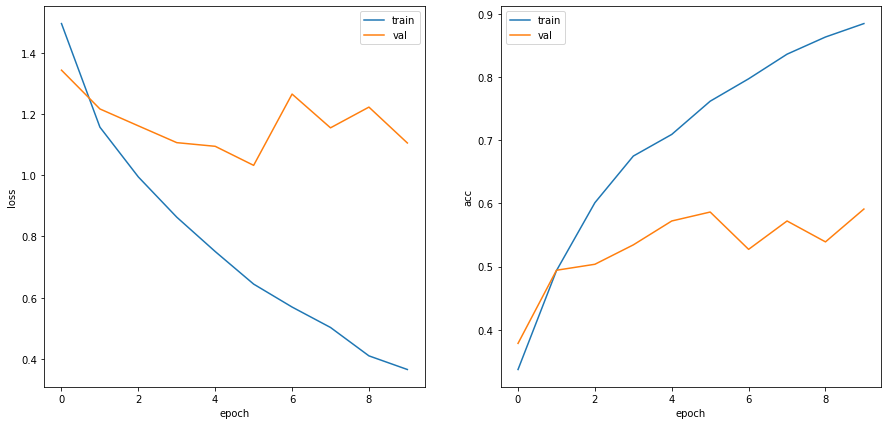

In [17]:
hist = loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])